# Побудова ансамблiв моделей класифiкацiї та регресiї засобами бiблiотеки Scikit-Learn Python

### Хиленко Валерія гр. КА-76, варіант №17

StackingClassifier. Розглянути рiзнi значення параметрiв final_estimator та stack_method.
Дослiдити ансамблi, якi включають моделi нейронних мереж та моделi на основi методу опорних векторiв з роботи №2.  
В моделях нейронних мереж:
- Використати рiзнi методи розрахунку ваг (параметр solver), порiвняти результати класифiкацiї, отриманi рiзними методами: ‘lbfgs’,‘sgd’, ‘adam’.
- Використати warm_start=True.

Ансамбль методов в машинном обучении использует несколько учебных алгоритмов с целью получения лучшей эффективности прогнозирования, чем могли бы получить от каждого учебного алгоритма отдельно.

##### Стекинг
Для определенности будем рассматривать задачу классификации (задача регрессии
рассматривается аналогично). Постановка задачи классификации звучит следующим
образом.
Пусть $X$ — множество описаний объектов, $Y$ — конечное множество номеров (имён, меток) классов. Существует неизвестная ”целевая зависимость” — отображение $f: X → Y$ значения которой известны только на объектах конечной обучаю-
щей выборки $(X, Y) = {(x_1 , y_1),..., (x_{|(X,Y)|}, y_{|(X,Y)|})}$. Требуется построить алгоритм $a: X → Y$, способный классифицировать произвольный объект $x ∈ X$.  
Идея стэкинга состоит в том, чтобы обучить метаклассификатор $M$ на (1) исходных признаках, матрице $X$, и (2) на предсказаниях (метапризнаках), полученных с помощью базовых классификаторов. Метапризнаки, полученные с помощью классификатора $A$ для выборки $X$ будем обозначать $MF(X, A)$. Принятым также является представление стекинга в виде многоуровневой схемы, где признаки обозначаются как ”уровень 0”, метапризнаки, полученные с помощью обучения базовых классификаторов на признаках, как ”уровень 1”, и так далее.
В простейшем виде получение предсказания для тестовой выборки $P$ с помощью стекинга выглядит следующим образом:  
<img src="stack.png">

##### Алгоритм
сделать разбиения ${{{(X_{n1}, Y_{n1}), (X_{n2}, Y_{n2})}, n=1...N}}$  
для $n=1...N$  
&emsp;$A_n:=A$  
&emsp;$A_n.fit(X_{n1}, Y_{n1})$  
&emsp;$MF(X_{n2}, A_n):=A_n.predict(X_{n2})$  
&emsp;$MF(X_0, A_n):=A_n.predict(X_0)$  
&emsp;$M_n := M$  
&emsp;$M_n.fit(concatV(X_{n2}, MF(X_{n2}, A_n)), Y_2)$  
&emsp;$P_n := M_n.predict(concatV(X_0, MF(X_0, A_n)))$   
$P:=\frac{1}{N}\sum_{i=1}^N P_n$

# 1. Взяти данi з роботи № 2

In [1]:
import numpy as np

In [2]:
from sklearn.datasets import make_blobs
n_samples_1 = 1000
n_samples_2 = 100
centers = [[0.0 , 0.0] , [2.0, 2.0]]
clusters_std = [1.5, 0.5]
X1, Y1 = make_blobs(n_samples=[n_samples_1, n_samples_2],        # generate 2d classification dataset
        centers=centers,
        cluster_std=clusters_std,
        random_state=0, shuffle=False)


from sklearn.datasets import load_wine
X2, Y2 = load_wine(return_X_y=True)

### Представити данi графiчно.

In [4]:
%matplotlib inline
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### make_blobs

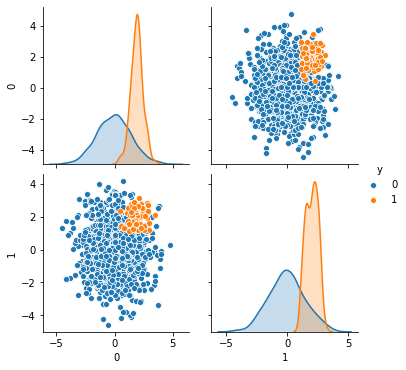

In [5]:
df1 = pd.DataFrame(X1)
df1['y'] = Y1.astype("int")
sns.pairplot(df1, hue='y')

### load_wine

In [6]:
raw_data = load_wine()
features = pd.DataFrame(data=raw_data['data'],columns=raw_data['feature_names'])
data = features
data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


#### Теплокарта кореляцій між ознаками

Квадрати з додатніми величинами показують кореляцію між ознаками. Чим більша величина, тим сильніше відношення.

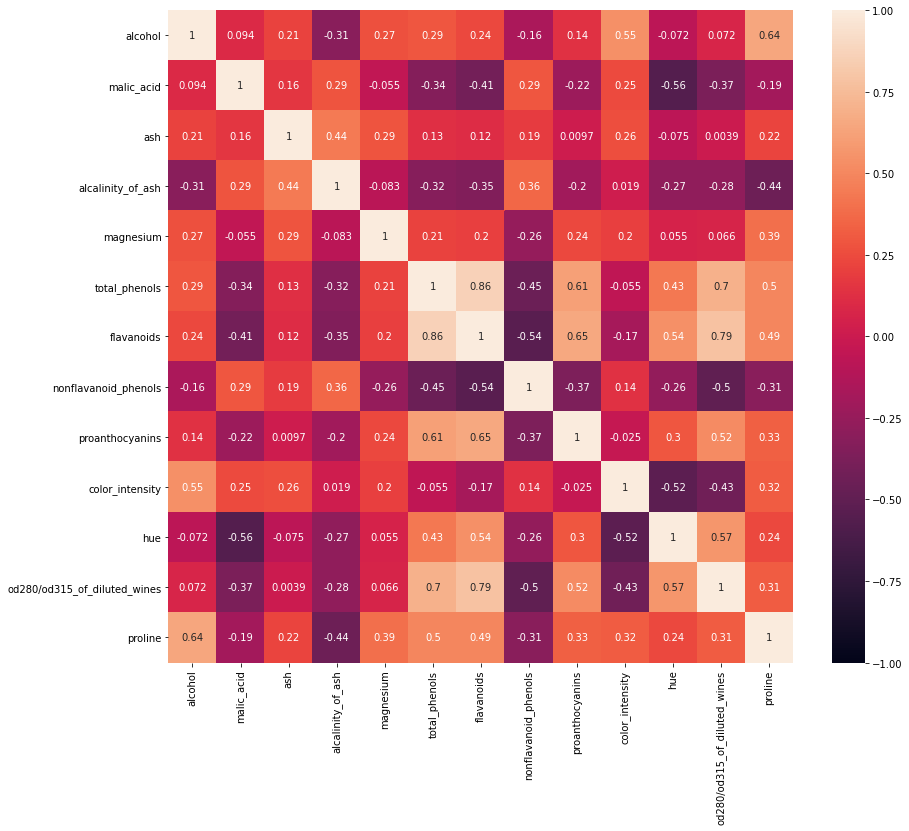

In [7]:
correlation = data.corr()
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1)

### Розбити данi на навчальний i перевiрочний набори.

In [5]:
from sklearn.preprocessing import StandardScaler
scaler1, scaler2 = StandardScaler(), StandardScaler()
X1 = scaler1.fit_transform(X1)
X2 = scaler2.fit_transform(X2)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=42)

# 2. - 4. Побудувати моделi нейронних мереж, використовуючи класи MLPClassifier для класифiкацiї. 
- Виконати прогнози на основi моделей.
- Для задач класифiкацiї розрахувати критерiї якостi для кожної моделi:
  -  матрицю неточностей (confusion matrix),
  -  точнiсть (precision),
  -  повноту (recall),
  -  мiру F1 (F1 score),
  -  ROCкриву, показник AUC.
  
Використати рiзнi методи розрахунку ваг (параметр solver), порiвняти результати класифiкацiї, отриманi рiзними методами: ‘lbfgs’,‘sgd’, ‘adam’.
Використати warm_start=True.

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve 

In [13]:
def plot_dec(X, y, title, clf):
    h = .02  # step size in the mesh

    # we create an instance of SVM and fit out data. We do not scale our
    # data since we want to plot the support vectors

    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    clf.fit(X, y)
    
    plt.figure(figsize=(12,12))
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [11]:
def metrics(true, predict, probs):
    #критерiї якостi для кожної моделi
    print("Confusion Matrix:\n", confusion_matrix(true, predict))
    print("Precision score: ", precision_score(true, predict))
    print("Recall score: ", recall_score(true, predict))
    print("F1 score: ", f1_score(true, predict))
    
    probs = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(true, probs)
    auc = roc_auc_score(true, probs)
    print(f"AUC score: {auc}")
    # ROC curve
    plt.plot(fpr, tpr)
    plt.title("ROC Curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

### make_blobs

Confusion Matrix:
 [[200   4]
 [  2  14]]
Precision score:  0.7777777777777778
Recall score:  0.875
F1 score:  0.823529411764706
AUC score: 0.9898897058823529


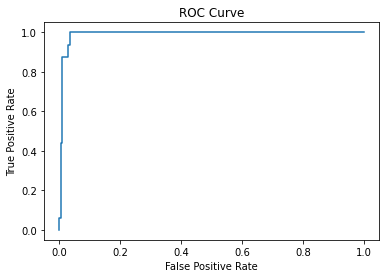

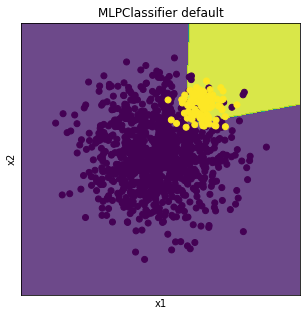

In [12]:
#create the model.
classifier = MLPClassifier(max_iter=500)
classifier.fit(X1_train, y1_train)
metrics(y1_test, classifier.predict(X1_test), probs=classifier.predict_proba(X1_test))
plot_dec(X1, Y1, "MLPClassifier default", classifier)

#### Використати рiзнi методи розрахунку ваг (параметр `solver`); порiвняти результати, отриманi методами ‘lbfgs’, ‘sgd’ та ‘adam’.

###### solver

    ‘lbfgs’ - оптимизатор семейства квазиньютоновских методов. 

    ‘sgd’ - стохастический градиентный спуск.

    ‘adam’ - относится к оптимизатору на основе стохастического градиента.

Confusion Matrix:
 [[197   7]
 [  0  16]]
Precision score:  0.6956521739130435
Recall score:  1.0
F1 score:  0.8205128205128205
AUC score: 0.9892769607843137


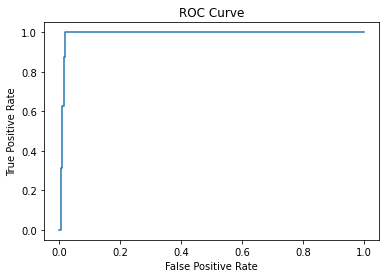

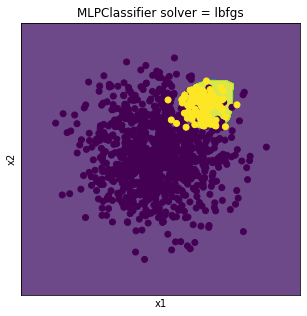

Confusion Matrix:
 [[201   3]
 [  3  13]]
Precision score:  0.8125
Recall score:  0.8125
F1 score:  0.8125
AUC score: 0.9892769607843138


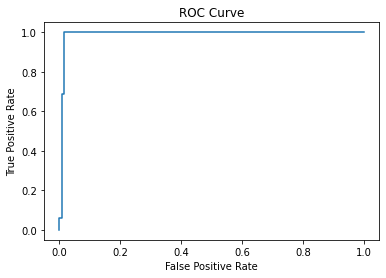

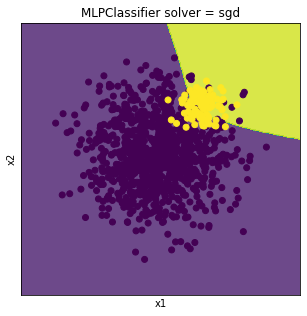

Confusion Matrix:
 [[199   5]
 [  2  14]]
Precision score:  0.7368421052631579
Recall score:  0.875
F1 score:  0.7999999999999999
AUC score: 0.9895833333333334


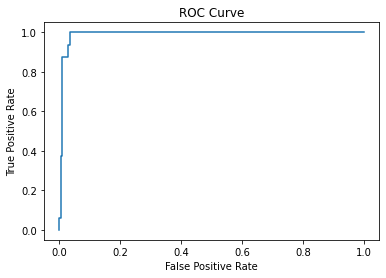

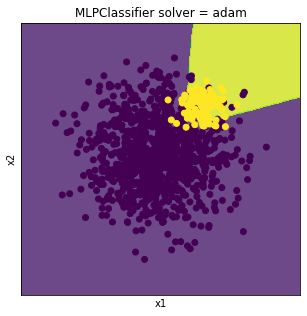

In [14]:
solver = ['lbfgs', 'sgd', 'adam']
for i in solver:
    classifier = MLPClassifier(solver = i, max_iter=1000)
    classifier.fit(X1_train, y1_train)
    metrics(y1_test, classifier.predict(X1_test), probs=classifier.predict_proba(X1_test))
    plot_dec(X1, Y1, f"MLPClassifier solver = {i}", classifier)

Як ми бачимо з графіків та даних метрик F1 score є найкращим для `sgd` та для `lbfgs`.

#### Використати warm_start = True

Confusion Matrix:
 [[200   4]
 [  1  15]]
Precision score:  0.7894736842105263
Recall score:  0.9375
F1 score:  0.8571428571428572
AUC score: 0.9865196078431373


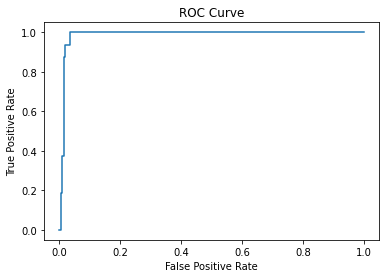

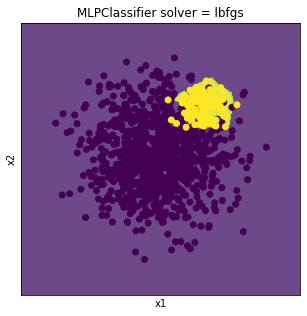

Confusion Matrix:
 [[202   2]
 [  3  13]]
Precision score:  0.8666666666666667
Recall score:  0.8125
F1 score:  0.8387096774193549
AUC score: 0.989889705882353


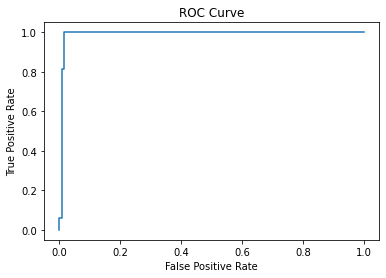

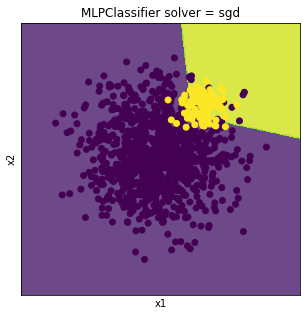

Confusion Matrix:
 [[199   5]
 [  2  14]]
Precision score:  0.7368421052631579
Recall score:  0.875
F1 score:  0.7999999999999999
AUC score: 0.9898897058823529


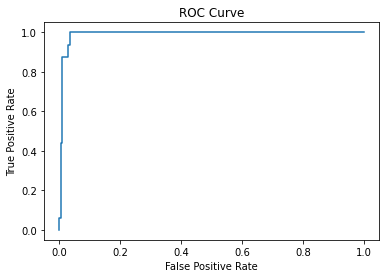

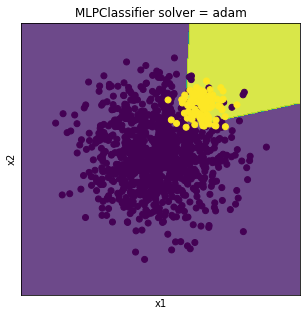

In [16]:
solver = ['lbfgs', 'sgd', 'adam']
for i in solver:
    classifier = MLPClassifier(solver = i, max_iter=2000, warm_start = True)
    classifier.fit(X1_train, y1_train)
    metrics(y1_test, classifier.predict(X1_test), probs=classifier.predict_proba(X1_test))
    plot_dec(X1, Y1, f"MLPClassifier solver = {i}", classifier)

Використовуючи `warm_start=True`, що дозволяє нам "продовжити" навчання з попередніх ваг, бачимо, що результат F1 score є найкращим для `lbfgs`.

### load_wines dataset 

In [17]:
from sklearn.metrics import classification_report

In [18]:
def metrics_lw(true, predict):
    #критерiї якостi для кожної моделi
    print("Confusion Matrix:\n", confusion_matrix(true, predict))
    print("Precision score: ", precision_score(true, predict, average='micro'))
    print("Recall score: ", recall_score(true, predict, average='micro'))
    print("F1 score: ", f1_score(true, predict, average='micro'))

In [19]:
#create the model.
classifier = MLPClassifier(max_iter=500)
classifier.fit(X2_train, y2_train)
metrics_lw(y2_test, classifier.predict(X2_test))

Confusion Matrix:
 [[14  0  0]
 [ 0 14  0]
 [ 0  0  8]]
Precision score:  1.0
Recall score:  1.0
F1 score:  1.0


#### Використати рiзнi методи розрахунку ваг (параметр solver); порiвняти результати, отриманi методами ‘lbfgs’, ‘sgd’ та ‘adam’.

In [20]:
solver = ['lbfgs', 'sgd', 'adam']
for i in solver:
    classifier = MLPClassifier(solver = i, max_iter=1000)
    print(f"MLPClassifier solver = {i}")
    classifier.fit(X2_train, y2_train)
    metrics_lw(y2_test, classifier.predict(X2_test))

MLPClassifier solver = lbfgs
Confusion Matrix:
 [[14  0  0]
 [ 0 14  0]
 [ 0  0  8]]
Precision score:  1.0
Recall score:  1.0
F1 score:  1.0
MLPClassifier solver = sgd
Confusion Matrix:
 [[14  0  0]
 [ 0 14  0]
 [ 0  0  8]]
Precision score:  1.0
Recall score:  1.0
F1 score:  1.0
MLPClassifier solver = adam
Confusion Matrix:
 [[14  0  0]
 [ 0 14  0]
 [ 0  0  8]]
Precision score:  1.0
Recall score:  1.0
F1 score:  1.0


#### Використати warm_start = True

In [21]:
solver = ['lbfgs', 'sgd', 'adam']
for i in solver:
    classifier = MLPClassifier(solver = i, max_iter=1000, warm_start = True)
    print(f"MLPClassifier solver = {i}")
    classifier.fit(X2_train, y2_train)
    metrics_lw(y2_test, classifier.predict(X2_test))

MLPClassifier solver = lbfgs
Confusion Matrix:
 [[14  0  0]
 [ 0 14  0]
 [ 0  0  8]]
Precision score:  1.0
Recall score:  1.0
F1 score:  1.0
MLPClassifier solver = sgd
Confusion Matrix:
 [[14  0  0]
 [ 0 14  0]
 [ 0  0  8]]
Precision score:  1.0
Recall score:  1.0
F1 score:  1.0
MLPClassifier solver = adam
Confusion Matrix:
 [[14  0  0]
 [ 0 14  0]
 [ 0  0  8]]
Precision score:  1.0
Recall score:  1.0
F1 score:  1.0


Результати F1 score однакові та дорівнюють 1, це означає, що нейронні мережі навчились дуже добре та алгоритм спрацював ідеально. 

## Настроїмо гiперпараметри за допомогою перехресної перевiрки. Для кожної навчальної вибiрки вибрати найкращу модель.

In [20]:
solver = ['lbfgs', 'sgd', 'adam']
warm_start = [True, False]

In [21]:
def grid_search(X_tr, y_tr, X_t, y_t):
    param=[]
    f1_scor=[]
    for s in solver:
        for w in warm_start:
            mlp = MLPClassifier(solver=s, warm_start = w, max_iter=5000).fit(X_tr, y_tr)
            param.append([s, w])
            f1_scor.append(f1_score(y_t, mlp.predict(X_t), average='micro'))
            
    return pd.DataFrame({"params[solver, warm_start]": param, "f1_score": f1_scor})

### make_blobs dataset

In [22]:
mlp_blobs = grid_search(X1_train, y1_train, X1_test, y1_test).set_index("params[solver, warm_start]")
pd.options.display.float_format = '{:.6f}'.format
mlp_blobs_sort = mlp_blobs.sort_values(["f1_score"], ascending=False)
mlp_blobs_sort.head()

,f1_score
"params[solver, warm_start]",
"[lbfgs, True]",0.981818
"[sgd, True]",0.972727
"[sgd, False]",0.972727
"[adam, False]",0.972727
"[lbfgs, False]",0.968182


Отже найкращими параметрами для make_blobs dataset є `{solver : lbfgs, warm_start: False}`

### load_wines dataset

In [26]:
mlp_digit = grid_search(X2_train, y2_train, X2_test, y2_test).set_index("params[solver, warm_start]")
pd.options.display.float_format = '{:.6f}'.format
mlp_digit_sort = mlp_digit.sort_values(["f1_score"], ascending=False)
mlp_digit_sort.head()

,f1_score
"params[solver, warm_start]",
"[lbfgs, True]",1.000000
"[lbfgs, False]",1.000000
"[sgd, True]",1.000000
"[sgd, False]",1.000000
"[adam, True]",1.000000


Результати F1 score однакові та дорівнюють 1, це означає, що нейронні мережі навчились дуже добре та алгоритм спрацював ідеально. Отож немає значення які параметри брати.

### Виконати прогнози на основi моделей нейронних мереж для найкращих параметрів. Виведемо значення функцiї втрат та значення середньої точностi класифiкацiї на навчальнiй i тестовiй множинах, використовуючи score

#### make_blobs dataset

Final train_f1 = 0.9727272727272728
Final test_f1 = 0.968181818181818

Mean accuracy:
Train_score = 0.9727272727272728
Tesr_score = 0.9681818181818181


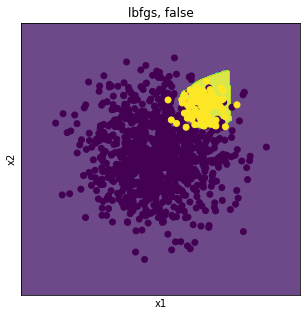

In [41]:
classifier = MLPClassifier(solver = 'lbfgs', max_iter=2000, warm_start = False)
classifier.fit(X1_train, y1_train)
#metrics(y1_test, classifier.predict(X1_test), probs=classifier.predict_proba(X1_test))

print(f"Final train_f1 = {f1_score(y1_train, classifier.predict(X1_train), average='micro')}")
print(f"Final test_f1 = {f1_score(y1_test, classifier.predict(X1_test), average='micro')}")
print("\nMean accuracy:")
print(f"Train_score = {classifier.score(X1_train, y1_train)}")
print(f"Tesr_score = {classifier.score(X1_test, y1_test)}")
plot_dec(X1, Y1, "lbfgs, false", classifier)

#### load_wine dataset

In [28]:
classifier = MLPClassifier(solver = 'lbfgs', max_iter=2000, warm_start = True)
classifier.fit(X2_train, y2_train)
print(f"Final train_f1 = {f1_score(y2_train, classifier.predict(X2_train), average='micro')}")
print(f"Final test_f1 = {f1_score(y2_test, classifier.predict(X2_test), average='micro')}")
print("\nMean accuracy:")
print(f"Train_score = {classifier.score(X2_train, y2_train)}")
print(f"Tesr_score = {classifier.score(X2_test, y2_test)}")

Final train_f1 = 1.0
Final test_f1 = 1.0

Mean accuracy:
Train_score = 1.0
Tesr_score = 1.0


## 5.-7. Побудувати ансамблi моделей, використовуючи наступнi методи згiдно з варiантом:

- StackingClassifier. Розглянути рiзнi значення параметрiв final_estimator та stack_method.
- Дослiдити ансамблi, якi включають моделi нейронних мереж та моделi на основi методу опорних векторiв з роботи №2. 

#### Побудувати ансамблi на основi найкращої моделi / моделей нейронних мереж, знайдених на попереднiх етапах даної роботи, та найкращої моделi / моделей, знайдених у роботi №2

Порiвняти результати класифiкацiї, значення мiр `F1_score` та `AUC` для ансамблiв та окремих моделей, якi утворюють цi ансамблi.

In [8]:
from sklearn.svm import NuSVC, SVC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

Будемо будувати ансамблі із найкращої SVC моделі взятої з роботи №2, та із найкращих MLP моделей (із 'lbfgs' solver)

In [12]:
# best NuSVC models from Lab 2
nusvc_params_blobs = {'degree': 1, 'nu': 0.1, 'probability': True}
nuSVC_blobs = NuSVC(**nusvc_params_blobs)

# best NuSVC models from Lab 2
nusvc_params_digit = {'degree': 1, 'nu': 0.4, 'probability': True}
nuSVC_digit = NuSVC(**nusvc_params_digit)

# best MLPClassifiers
MLP_blobs = MLPClassifier(solver = 'lbfgs', max_iter=2000, warm_start = False)
MLP_digit = MLPClassifier(solver = 'lbfgs', max_iter=2000, warm_start = True)

estimators_blobs = [('nuSVC_blobs', nuSVC_blobs), ('MLP_blobs', MLP_blobs)]
estimators_digits = [('nuSVC_digit', nuSVC_digit), ('MLP_digit', MLP_digit)]

final_estimators = [NuSVC(), SVC(), MLPClassifier(max_iter=2000), DecisionTreeClassifier(), LogisticRegression()]
stack_methods = ['auto', 'predict_proba', 'decision_function', 'predict']

In [13]:
def grid_search_stacking_classifier(X_train, y_train, X_test, y_test, estimators, return_best=3, final_estimators=final_estimators, stack_methods=stack_methods, binary = False):
    results = {"final_estimator" : [], "stack_method" : [], "test_f1_score" : [], 
               "mlp_f1": [], "svc_f1": [], "mlp_roc_auc":[],
               "svc_roc_auc": []}
    
    estimators[0][1].fit(X_train, y_train)
    estimators[1][1].fit(X_train, y_train)
    for final_estimator in final_estimators:
        for stack_method in stack_methods:
            try:
                scc = StackingClassifier(estimators, final_estimator=final_estimator, cv=5, stack_method=stack_method, n_jobs=-1)
                scc.fit(X_train, y_train)
                results['test_f1_score'].append(f1_score(y_test, scc.predict(X_test), average='micro'))
                results['final_estimator'].append(final_estimator)
                results['stack_method'].append(stack_method)
                results['mlp_f1'].append(f1_score(y_test, estimators[1][1].predict(X_test) , average='micro'))
                results['svc_f1'].append(f1_score(y_test, estimators[0][1].predict(X_test) , average='micro'))
                if binary == False:
                    probs1=estimators[1][1].predict_proba(X_test)
                    probs1 = probs1[:, 1]
                    probs2=estimators[0][1].predict_proba(X_test)
                    probs2 = probs2[:, 1] 
                    #probs_test = scc.predict_proba(X_test)[:, 1] 
                else:
                    probs1=estimators[1][1].predict_proba(X_test)
                    probs2=estimators[0][1].predict_proba(X_test)
                    #probs_test = scc.predict_proba(X_test)
                results['mlp_roc_auc'].append(roc_auc_score(y_test, probs1, multi_class = 'ovo'))
                results['svc_roc_auc'].append(roc_auc_score(y_test, probs2, multi_class = 'ovo'))
            except Exception as e:
                #print("Method not supported", e)
                pass
    results_df = pd.DataFrame.from_dict(results, orient='index') 
    return results_df

#### make_blobs dataset

In [16]:
results_df_blobs = grid_search_stacking_classifier(X1_train, y1_train, X1_test, y1_test, estimators_blobs)
results_df_blobs.transpose().sort_values(by='test_f1_score', ascending = False)

,final_estimator,stack_method,test_f1_score,mlp_f1,svc_f1,mlp_roc_auc,svc_roc_auc
5,"MLPClassifier(activation='relu', alpha=0.0001,...",predict,0.981818,0.963636,0.968182,0.990502,0.99326
3,"MLPClassifier(activation='relu', alpha=0.0001,...",auto,0.977273,0.963636,0.968182,0.990502,0.99326
9,"LogisticRegression(C=1.0, class_weight=None, d...",auto,0.977273,0.963636,0.968182,0.990502,0.99326
10,"LogisticRegression(C=1.0, class_weight=None, d...",predict_proba,0.977273,0.963636,0.968182,0.990502,0.99326
0,"SVC(C=1.0, break_ties=False, cache_size=200, c...",auto,0.968182,0.963636,0.968182,0.990502,0.99326
1,"SVC(C=1.0, break_ties=False, cache_size=200, c...",predict_proba,0.968182,0.963636,0.968182,0.990502,0.99326
2,"SVC(C=1.0, break_ties=False, cache_size=200, c...",predict,0.968182,0.963636,0.968182,0.990502,0.99326
4,"MLPClassifier(activation='relu', alpha=0.0001,...",predict_proba,0.968182,0.963636,0.968182,0.990502,0.99326
8,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",predict,0.968182,0.963636,0.968182,0.990502,0.99326
11,"LogisticRegression(C=1.0, class_weight=None, d...",predict,0.968182,0.963636,0.968182,0.990502,0.99326


In [18]:
best_enseble_blobs = results_df_blobs.transpose().sort_values(by='test_f1_score').tail(1)["final_estimator"].values[0]
print(best_enseble_blobs)
print(f"For ensemble on make blobs dataset, best f1_score = {results_df_blobs.transpose().sort_values(by='test_f1_score').tail(1)['test_f1_score'].values[0]}")

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=2000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
For ensemble on make blobs dataset, best f1_score = 0.9818181818181818


In [19]:
scc = StackingClassifier(estimators_blobs, final_estimator=MLPClassifier(max_iter=2000), cv=5, stack_method='predict_proba', n_jobs=-1)
scc.fit(X1_train, y1_train)
print(f"AUC score for ensemble = {roc_auc_score(y1_test, scc.predict_proba(X1_test)[:, 1])}")

AUC score for ensemble = 0.9932598039215687


#### Digits dataset

In [64]:
results_df_digits = grid_search_stacking_classifier(X2_train, y2_train, X2_test, y2_test, estimators_digits, binary = True)
results_df_digits.transpose().sort_values(by='test_f1_score', ascending = False)

,final_estimator,stack_method,test_f1_score,mlp_f1,svc_f1,mlp_roc_auc,svc_roc_auc
0,"NuSVC(break_ties=False, cache_size=200, class_...",auto,1.000000,1.000000,1.000000,1.000000,1.000000
1,"NuSVC(break_ties=False, cache_size=200, class_...",predict_proba,1.000000,1.000000,1.000000,1.000000,1.000000
2,"NuSVC(break_ties=False, cache_size=200, class_...",predict,1.000000,1.000000,1.000000,1.000000,1.000000
3,"SVC(C=1.0, break_ties=False, cache_size=200, c...",auto,1.000000,1.000000,1.000000,1.000000,1.000000
4,"SVC(C=1.0, break_ties=False, cache_size=200, c...",predict_proba,1.000000,1.000000,1.000000,1.000000,1.000000
5,"SVC(C=1.0, break_ties=False, cache_size=200, c...",predict,1.000000,1.000000,1.000000,1.000000,1.000000
6,"MLPClassifier(activation='relu', alpha=0.0001,...",auto,1.000000,1.000000,1.000000,1.000000,1.000000
7,"MLPClassifier(activation='relu', alpha=0.0001,...",predict_proba,1.000000,1.000000,1.000000,1.000000,1.000000
8,"MLPClassifier(activation='relu', alpha=0.0001,...",predict,1.000000,1.000000,1.000000,1.000000,1.000000
9,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",auto,1.000000,1.000000,1.000000,1.000000,1.000000


In [65]:
best_enseble_digits = results_df_digits.transpose().sort_values(by='test_f1_score').tail(1)["final_estimator"].values[0]
print(best_enseble_digits)
print(f"For ensemble on digit dataset, best f1_score = {results_df_digits.transpose().sort_values(by='test_f1_score').tail(1)['test_f1_score'].values[0]}")

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
For ensemble on digit dataset, best f1_score = 1.0


In [73]:
scc = StackingClassifier(estimators_digits, final_estimator=MLPClassifier(max_iter=2000), cv=5, stack_method='predict_proba', n_jobs=-1)
scc.fit(X2_train, y2_train)
print(f"AUC score for ensemble = {roc_auc_score(y2_test, scc.predict_proba(X2_test), multi_class = 'ovo')}")

AUC score for ensemble = 1.0


#### Висновок: 
Модель, що була отримана завдяки ансамблванню виявилася більше ефективною, ніж просто модель `MLPClassifier`. Також нам вдалось отримати на digits датасеті найкращий f1_score = 1, що у `MLPClassifier`, що завдяки ансамблюванню. 

**Метрики найкращих моделей ансамблювання:**

На **make blobs датасеті**, найкраща модель StackingClassifier із:
- Характеристики моделі:
    - final_estimator `MLPClassifier()`
    - learning_rate `predict`,
    - f1_score `0.981818 `
    - roc_auc_score `0.9932598`
- Характиристики використаних estimator-ів 
    - best MLP model `mlp_blobs`
    - mlp_blobs f1_score  `0.972727`
    - svc() f1_score `0.968182`
    - mlp_blobs roc_auc_score`0.989890 `
    - svc() roc_auc_score `0.993260`

    
На **digits датасеті**, всі моделі ефективні.

Отже, можна зробити висновок, що за допомогою ансамблювання нам вдалось покращити результати. 

Проте, є ще велика кількість параметрів, які можна додатково підлаштувати. Окрім гіперпараметрів  StackingClassifier можна паралельно підлаштовувати також параметри і моделей, які стакуються. До того ж, можна спробувати інші моделі для ансамблювання. 